* To compared the overall averaged surface salinity between bathymetry 5 & 2.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import scipy.io as sio
import glob
import os
from datetime import timedelta
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.})

In [2]:
## load bathymetry
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
grid5 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')

In [3]:
## load averaged file
gridT_2 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/Average_nowcast/1629_T.nc')
gridT_5 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_norefraserxml/16jun15/1629_5_T.nc')

In [4]:
## extract averaged salinity
S_1629_2 = gridT_2.variables['vosaline'][0]
S_1629_5 = gridT_5.variables['vosaline'][0]
lon = gridT_2.variables['nav_lon']
lat = gridT_2.variables['nav_lat']

In [5]:
def find_route(saline, route_name, today):
    struct= (((saline['%s_TSG' %route_name])['output'])[0,0])['Practical_Salinity'][0,0]
    salinity = struct['data'][0,0]
    time = struct['matlabTime'][0,0]
    lonn = struct['longitude'][0,0]
    latt = struct['latitude'][0,0]
    
   
    a=len(time)
    lon1=np.zeros([a,1])
    lat1=np.zeros([a,1])
    salinity1=np.zeros([a,1])

    if route_name == 'HBDB':       
        run_lower = today.replace(hour = 1, minute = 30)
        run_upper = today.replace(hour= 4, minute = 20)
    elif route_name =='TWDP':
        run_lower = today.replace(hour = 3, minute =15,second = 0, microsecond = 0)
        run_upper = today.replace(hour= 5, minute=15,second = 0, microsecond = 0)
    elif route_name =='TWSB':
        run_lower = today.replace(hour = 2, minute=0)
        run_upper = today.replace(hour= 4, minute=0) 
    else:
        print ('This is not a station!')
    for i in np.arange(0,a):
        matlab_datenum = np.float(time[i])
        python_datetime = datetime.datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
        
        if (python_datetime >= run_lower) &(python_datetime <= run_upper):
            lon1[i]=lonn[i]
            lat1[i]=latt[i]
            salinity1[i]=salinity[i]
            
    mask=lon1[:,0]!=0
    lon1_2_4=lon1[mask]
    lat1_2_4=lat1[mask]
    salinity1_2_4=salinity1[mask]
    lon11=lon1_2_4[0:-1:20]
    lat11=lat1_2_4[0:-1:20]
    salinity11=salinity1_2_4[0:-1:20]

    return lon11,lat11

In [6]:
day = datetime.datetime(2016,4,21)
run_date= datetime.datetime(2016,4,20)
route = 'TWDP'
date_str_yesterday = run_date.strftime('%Y%m%d')
saline=sio.loadmat('/ocean/jieliu/research/meopar/ONC_ferries/%s/%s_TSG%s.mat' %(route, 'route, date_str_yesterday))
lon11, lat11 = find_route(saline, route, day)

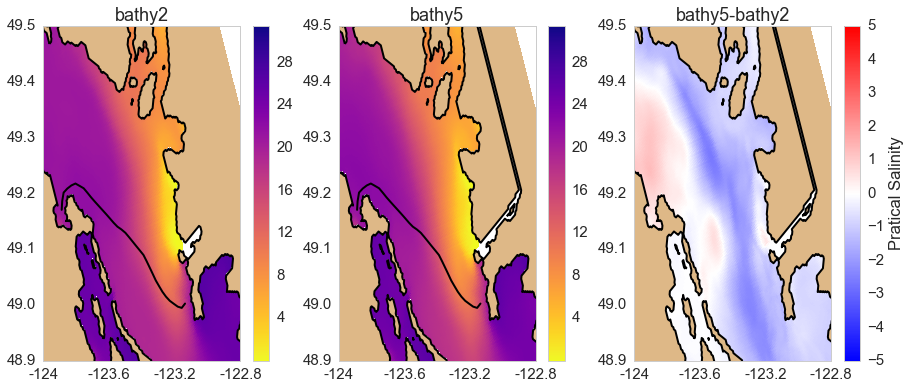

In [11]:
fig, axs = plt.subplots(1,3,figsize = (15,6))
for ax,S,grid,string in zip([axs[0],axs[1]], [S_1629_2,S_1629_5], 
                            [grid2,grid5], ['bathy2','bathy5']):
    mesh = ax.pcolormesh(lon,lat,np.ma.masked_values(S[0],0),cmap = 'plasma_r') ## look a te surface
    cbar = fig.colorbar(mesh, ax =ax)      
    ax.plot(lon11,lat11,color='k')
    ax.set_title(string)
ax = axs[-1]
mesh = ax.pcolormesh(lon,lat,np.ma.masked_values(S_1629_5[0] - S_1629_2[0],0), vmin = -5, vmax = 5,cmap = 'bwr')
cbar = fig.colorbar(mesh,ax =ax)
ax.set_title('bathy5-bathy2')

for ax in axs:
    ax.set_xlim([-124.,-122.8])
    ax.set_xticks([-124,-123.6,-123.2,-122.8])
    ax.set_ylim([48.9,49.5])
    cbar.set_label('Pratical Salinity')
    viz_tools.plot_land_mask(ax,grid,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid, coords = 'map')